# ***Merge & Balance DataSEt***

In [ ]:
import kagglehub
organizations__path = kagglehub.dataset_download('datafiniti/consumer-reviews-of-amazon-products')

print('Data source import complete.')

In [ ]:
import pandas as pd
import re
from sklearn.utils import resample

try:
    df1 = pd.read_csv("/kaggle/input/consumer-reviews-of-amazon-products/1429_1.csv", low_memory=False)
except Exception as e:
    print(f"Error loading df1: {e}")
    df1 = pd.DataFrame()

try:
    df2 = pd.read_csv("/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv", low_memory=False)
except Exception as e:
    print(f"Error loading df2: {e}")
    df2 = pd.DataFrame()

try:
    df3 = pd.read_csv("/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv", low_memory=False)
except Exception as e:
    print(f"Error loading df3: {e}")
    df3 = pd.DataFrame()

combined_data = pd.concat([df1, df2, df3], ignore_index=True, join='outer')
print("Data combined successfully.")
print(f"Initial combined data shape: {combined_data.shape}")

if 'reviews.text' in combined_data.columns and 'reviews.rating' in combined_data.columns:
    combined_data = combined_data[['reviews.text', 'reviews.rating']]
    print("Kept only 'reviews.text' and 'reviews.rating' columns.")
else:
    print("Error: Required columns 'reviews.text' or 'reviews.rating' not found in combined data.")
    exit()

initial_rows = len(combined_data)
combined_data.dropna(subset=['reviews.text', 'reviews.rating'], inplace=True)
rows_after_na = len(combined_data)
print(f"Removed {initial_rows - rows_after_na} rows with missing values.")

initial_rows = len(combined_data)
combined_data = combined_data.drop_duplicates()
rows_after_duplicates = len(combined_data)
print(f"Removed {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"Data shape after cleaning: {combined_data.shape}")

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

combined_data['cleaned_review'] = combined_data['reviews.text'].apply(clean_text)
print("Text cleaning applied.")

try:
    combined_data['reviews.rating'] = combined_data['reviews.rating'].astype(int)
except ValueError as e:
    print(f"Error converting 'reviews.rating' to integer: {e}. Attempting to remove non-numeric ratings.")
    combined_data = combined_data[pd.to_numeric(combined_data['reviews.rating'], errors='coerce').notnull()]
    combined_data['reviews.rating'] = combined_data['reviews.rating'].astype(int)

combined_data['sentiment'] = combined_data['reviews.rating'].apply(
    lambda x: 'Negative' if x in [1, 2] else ('Neutral' if x == 3 else 'Positive')
)

combined_data['label'] = combined_data['sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})
print("Sentiment and label columns created.")
print("\nDistribution before balancing:")
print(combined_data['sentiment'].value_counts())

positive_reviews = combined_data[combined_data['sentiment'] == 'Positive']
neutral_reviews = combined_data[combined_data['sentiment'] == 'Neutral']
negative_reviews = combined_data[combined_data['sentiment'] == 'Negative']

if positive_reviews.empty or neutral_reviews.empty or negative_reviews.empty:
    print("\nWarning: One or more sentiment classes are empty. Balancing cannot be performed as intended.")
    balanced_data = combined_data
else:
    max_count = max(len(positive_reviews), len(neutral_reviews), len(negative_reviews))
    print(f"\nTarget count for each class (oversampling based on combined_data): {max_count}")

    balanced_positive = resample(positive_reviews,
                                 replace=True,
                                 n_samples=max_count,
                                 random_state=42)

    balanced_neutral = resample(neutral_reviews,
                                replace=True,
                                n_samples=max_count,
                                random_state=42)

    balanced_negative = resample(negative_reviews,
                                 replace=True,
                                 n_samples=max_count,
                                 random_state=42)

    balanced_data = pd.concat([balanced_positive, balanced_neutral, balanced_negative], ignore_index=True)

    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
    print("\nBalancing complete using oversampling.")
    print("\nDistribution after balancing:")
    print(balanced_data['sentiment'].value_counts())

final_columns = ['sentiment', 'cleaned_review', 'label']
if all(col in balanced_data.columns for col in final_columns):
    balanced_data_final = balanced_data[final_columns]
    print("\nSelected final columns for the balanced dataset.")
    print("\nFinal balanced data structure:")
    print(balanced_data_final.info())
    print("\nFirst 5 rows of the final balanced data:")
    print(balanced_data_final.head())
else:
    print(f"Error: Could not find all required final columns {final_columns} in the balanced data.")
    balanced_data_final = pd.DataFrame()



Data combined successfully.
Initial combined data shape: (67992, 27)
Kept only 'reviews.text' and 'reviews.rating' columns.
Removed 34 rows with missing values.
Removed 20953 duplicate rows.
Data shape after cleaning: (47005, 2)
Text cleaning applied.
Sentiment and label columns created.

Distribution before balancing:
sentiment
Positive    43094
Neutral      2068
Negative     1843
Name: count, dtype: int64

Target count for each class (oversampling based on combined_data): 43094

Balancing complete using oversampling.

Distribution after balancing:
sentiment
Neutral     43094
Negative    43094
Positive    43094
Name: count, dtype: int64

Selected final columns for the balanced dataset.

Final balanced data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129282 entries, 0 to 129281
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   sentiment       129282 non-null  object
 1   cleaned_review  129282

<ipython-input-3-33bb47677aae>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment',


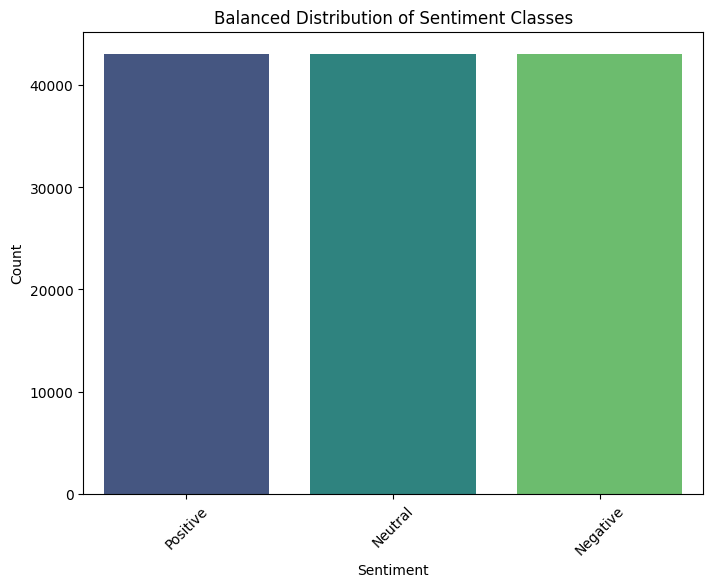

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'balanced_data_final' in locals() and not balanced_data_final.empty:
    plt.figure(figsize=(8, 6))

    sns.countplot(x='sentiment',
                  data=balanced_data_final,
                  palette='viridis',
                  order=['Positive', 'Neutral', 'Negative'])

    plt.title('Balanced Distribution of Sentiment Classes')

    plt.xlabel('Sentiment')

    plt.ylabel('Count')

    plt.xticks(rotation=45)

    plt.show()
else:
    print("DataFrame 'balanced_data_final' is not defined or is empty. Cannot generate plot.")

# ***Classification***

In [ ]:
import kagglehub
organizations__path = kagglehub.dataset_download('datafiniti/consumer-reviews-of-amazon-products')

print('Data source import complete.')

Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Still needed to get a test set
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from transformers import pipeline, AutoTokenizer # Import pipeline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # For progress bar

In [ ]:
# --- Settings ---

DATASET_PATH = "/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
TEXT_COLUMN = 'reviews.text'
RATING_COLUMN = 'reviews.rating'


In [ ]:
MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest' # Let's use this one


In [ ]:
# --- 2. Load Data ---
try:
    df = pd.read_csv(DATASET_PATH)
    print("Data loaded successfully.")
    print(f"Initial number of rows: {len(df)}")
except FileNotFoundError:
    print(f"Error: File not found at '{DATASET_PATH}'. Please upload the file and update the path.")
    # Using dummy data for demonstration if file not found
    data = {
        TEXT_COLUMN: ["Great product, loved it!", "It broke after one day.", "It's okay, does the job.", "Amazing value for money.", "Not worth the price.", "Average quality.", "I order 3 of them and one of the item is bad q...", "Bulk is always the less expensive way to go fo...", "Well they are not Duracell but for the price i..."],
        RATING_COLUMN: [5, 1, 3, 5, 2, 3, 3, 4, 5]
    }
    df = pd.DataFrame(data)
    print("Using dummy data for testing.")

Data loaded successfully.
Initial number of rows: 28332


In [ ]:
# --- 3. Preprocess Data (to get ground truth labels for evaluation) ---
# Select necessary columns
df_subset = df[[TEXT_COLUMN, RATING_COLUMN]].copy()

In [ ]:
# Drop rows with missing values in essential columns
df_subset.dropna(subset=[TEXT_COLUMN, RATING_COLUMN], inplace=True)


In [ ]:
# Ensure rating column is numeric and integer type
df_subset[RATING_COLUMN] = pd.to_numeric(df_subset[RATING_COLUMN], errors='coerce')
df_subset.dropna(subset=[RATING_COLUMN], inplace=True)
df_subset[RATING_COLUMN] = df_subset[RATING_COLUMN].astype(int)



In [ ]:
print(f"Number of rows after cleaning: {len(df_subset)}")

if len(df_subset) == 0:
  print("No data remaining after cleaning!")
  exit()


Number of rows after cleaning: 28332


In [ ]:
# Function to map star ratings to sentiment labels (our ground truth)
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    elif rating in [4, 5]:
        return 'Positive'
    else:
        return None # Should not happen after cleaning

In [ ]:
# Create the ground truth sentiment label column
df_subset['true_sentiment_label'] = df_subset[RATING_COLUMN].apply(map_rating_to_sentiment)
df_subset.dropna(subset=['true_sentiment_label'], inplace=True)


In [ ]:
# Define the possible labels for consistency in evaluation later
labels = ['Negative', 'Neutral', 'Positive']


In [ ]:
print("\nGround truth label distribution:")
print(df_subset['true_sentiment_label'].value_counts())



Ground truth label distribution:
true_sentiment_label
Positive    25545
Negative     1581
Neutral      1206
Name: count, dtype: int64


In [ ]:
# --- 4. Split Data (We only need the test set for evaluation) ---
# We split primarily to simulate evaluating on unseen data.
# The model itself is already trained, we don't need a training set for it.
_, test_df = train_test_split(df_subset, test_size=0.2, random_state=42, stratify=df_subset['true_sentiment_label'])

print(f"\nSize of test set for evaluation: {len(test_df)}")



Size of test set for evaluation: 5667


In [ ]:
# --- 5. Load Ready-Made Sentiment Analysis Pipeline ---
print(f"\nLoading sentiment analysis pipeline for model: {MODEL_NAME}...")
# device=0 will use GPU if available, otherwise change to device=-1 for CPU
try:
    classifier = pipeline("sentiment-analysis", model=MODEL_NAME, tokenizer=MODEL_NAME, device=0)
    print("Pipeline loaded successfully on GPU.")
except Exception as e:
    print(f"Could not load pipeline on GPU ({e}). Trying CPU...")
    classifier = pipeline("sentiment-analysis", model=MODEL_NAME, tokenizer=MODEL_NAME, device=-1)
    print("Pipeline loaded successfully on CPU.")



Loading sentiment analysis pipeline for model: cardiffnlp/twitter-roberta-base-sentiment-latest...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Pipeline loaded successfully on GPU.


In [ ]:
# --- 6. Make Predictions on the Test Set ---
test_texts = list(test_df[TEXT_COLUMN])
print(f"\nMaking predictions on {len(test_texts)} reviews...") # Should print 5667
batch_size = 64
predictions = [] # List to store raw pipeline output
for i in tqdm(range(0, len(test_texts), batch_size)):
    batch = test_texts[i:i+batch_size]
    # Specify max_length for truncation and padding
    predictions.extend(classifier(batch, truncation=True, padding=True, max_length=512))

print("Predictions completed.")


# Check the actual number of predictions received from the pipeline
print(f"Length of raw predictions list: {len(predictions)}")






Making predictions on 5667 reviews...


  0%|          | 0/89 [00:00<?, ?it/s]

Predictions completed.
Length of raw predictions list: 5667


In [ ]:
# --- 7. Extract Predicted Labels and Map if Necessary ---
predicted_labels = [] # List to store the final mapped labels
label_map = { # Define mapping based on expected output from the chosen model
    'positive': 'Positive',
    'negative': 'Negative',
    'neutral': 'Neutral',
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive',
}




In [ ]:
# This loop iterates over the 'predictions' list
for prediction in predictions:
    raw_label = prediction['label'].lower()
    mapped_label = label_map.get(raw_label, 'Unknown')
    predicted_labels.append(mapped_label)




In [ ]:
# Add predicted labels to the test dataframe for easy comparison
# This line will fail if len(predicted_labels) != len(test_df)
test_df['predicted_sentiment_label'] = predicted_labels

In [ ]:
# Filter out any 'Unknown' predictions if they occurred and we want to exclude them from metrics
test_df_filtered = test_df[test_df['predicted_sentiment_label'] != 'Unknown'].copy()
y_true = test_df_filtered['true_sentiment_label']
y_pred = test_df_filtered['predicted_sentiment_label']


In [ ]:
if len(test_df_filtered) < len(test_df):
     print(f"\nWarning: {len(test_df) - len(test_df_filtered)} predictions resulted in 'Unknown' labels and were excluded from evaluation.")

# --- 8. Evaluate the Ready-Made Model's Performance ---
print("\n--- Evaluating the ready-made model ---")



--- Evaluating the ready-made model ---



Overall Accuracy: 0.8699
Weighted Precision: 0.9180
Weighted Recall: 0.8699
Weighted F1-score: 0.8908

--- Confusion Matrix ---


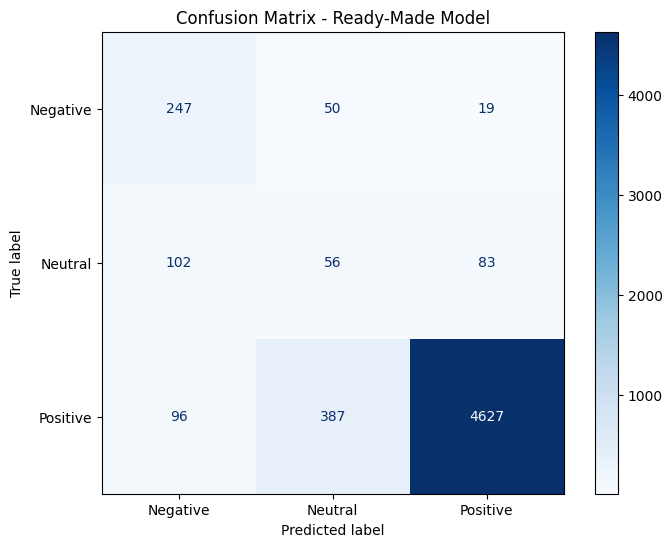


--- Classification Report ---
              precision    recall  f1-score   support

    Negative       0.56      0.78      0.65       316
     Neutral       0.11      0.23      0.15       241
    Positive       0.98      0.91      0.94      5110

    accuracy                           0.87      5667
   macro avg       0.55      0.64      0.58      5667
weighted avg       0.92      0.87      0.89      5667



In [ ]:
if len(y_true) == 0:
    print("No valid predictions available for evaluation.")
else:
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, f1-score (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', labels=labels, zero_division=0)
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-score: {f1:.4f}")

    # Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred, labels=labels) # Ensure labels are in consistent order
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Ready-Made Model')
    plt.show()

    # Classification Report (shows metrics per class)
    print("\n--- Classification Report ---")
    # Ensure target_names matches the order in 'labels'
    print(classification_report(y_true, y_pred, target_names=labels, labels=labels, zero_division=0))


# ***Clustring_K-MEANS***

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import torch # Or tensorflow if you prefer


In [ ]:
# --- Download necessary NLTK data ---
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    word_tokenize("example text")
except LookupError:
    nltk.download('punkt')
try:
    sent_tokenize("example text.")
except LookupError:
    nltk.download('punkt') # Punkt is needed for both word and sentence tokenization

print("Libraries imported and NLTK data checked/downloaded.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Libraries imported and NLTK data checked/downloaded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# --- Configuration ---
print("\n--- Configuration ---")
# Assuming dataset is downloaded via kagglehub or available at a path
# Replace with your actual path if not using kagglehub's default location
# Common kagglehub path: '/root/.kaggle/datasets/datafiniti/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
# Or Kaggle input path: '/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
DATASET_PATH = '/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
N_CLUSTERS_TARGET = 5 # Target number of clusters (within 4-6 range)
TOP_N_PRODUCTS = 3
TOP_N_KEYWORDS = 10 # Number of keywords to extract for complaints/praises
# Summarization model - 't5-small' is fast, 't5-base' or 'bart-large-cnn' might be better but slower
# SUMMARIZER_MODEL_NAME = "t5-small"
SUMMARIZER_MODEL_NAME = "google/flan-t5-large" # Flan-T5 often better for instruction following



--- Configuration ---


In [ ]:
# --- 2. Load Data ---
print("\n--- 2. Loading Data ---")
try:
    df = pd.read_csv(DATASET_PATH)
    # Basic cleaning - remove rows where essential review info is missing
    df.dropna(subset=['asins', 'name', 'reviews.text', 'reviews.rating'], inplace=True)
    df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce')
    df.dropna(subset=['reviews.rating'], inplace=True)
    df['reviews.rating'] = df['reviews.rating'].astype(int)
    print(f"Data loaded successfully. Shape after initial cleaning: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at '{DATASET_PATH}'. Please verify the path.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading or initial cleaning: {e}")
    exit()



--- 2. Loading Data ---
Data loaded successfully. Shape after initial cleaning: (28332, 24)


In [ ]:
# --- 3. Clustering Function ---
print("\n--- 3. Clustering Function Definition ---")
def perform_clustering(input_df, n_clusters):
    """
    Performs TF-IDF based K-Means clustering on product categories.

    Args:
        input_df (pd.DataFrame): DataFrame containing product information including 'asins', 'name', 'categories'.
        n_clusters (int): The desired number of clusters (K).

    Returns:
        tuple: (products_df, cluster_to_meta_category_map) or (None, None) if failed.
               products_df contains unique products with cluster labels.
               cluster_to_meta_category_map is the mapping from cluster ID to name.
    """
    print(f"\n--- Performing Clustering for K={n_clusters} ---")
    if not all(col in input_df.columns for col in ['asins', 'categories', 'name']):
        print("Error: Input DataFrame is missing required columns ('asins', 'categories', 'name').")
        return None, None

    # Create DataFrame with unique products (based on ASIN)
    products_df = input_df.groupby('asins').agg(
        name=('name', 'first'),
        categories=('categories', 'first')
    ).reset_index()
    products_df.dropna(subset=['categories'], inplace=True)
    print(f"Number of unique products for clustering: {len(products_df)}")
    if len(products_df) < n_clusters:
        print(f"Warning: Number of unique products ({len(products_df)}) is less than the desired number of clusters ({n_clusters}).")
        if len(products_df) == 0: return None, None
        # Consider reducing n_clusters or handling this case if proceeding

    # --- Define the advanced preprocessing function ---
    def preprocess_category_text_advanced(text):
        if isinstance(text, str):
            # Advanced cleaning: remove non-alphanumeric except spaces/commas, split robustly
            text = re.sub(r'[^\w\s,]', '', text) # Keep commas for structure if useful
            parts = [part.strip() for part in re.split(r'[,\/&]| and ', text.lower()) if part.strip() and len(part)>1] # Split by common separators
            # Optional: remove very generic terms
            generic_terms = {'electronics', 'accessories', 'supplies', 'home', 'household', 'care', 'beauty', 'health', 'tools', 'kitchen', 'photo', 'camera'}
            parts = [p for p in parts if p not in generic_terms]
            # Use unique terms, sorted
            parts = sorted(list(set(parts)))
            return ' '.join(parts) # Return space-separated string for TF-IDF
        return "" # Return empty string for non-strings or failed processing

    # --- Apply the function to create the new column ---
    products_df['processed_category_string'] = products_df['categories'].apply(preprocess_category_text_advanced)

    # --- Filter out empty strings *after* applying the function ---
    products_df = products_df[products_df['processed_category_string'].str.len() > 0].copy() # Use .copy()
    print(f"Number of unique products after advanced category processing: {len(products_df)}")

    if len(products_df) < n_clusters: # Check again after filtering
        print(f"Error: Not enough products with processable categories remain ({len(products_df)}) for {n_clusters} clusters.")
        return None, None # Return None to signal failure downstream

    # --- Vectorization using TF-IDF ---
    print("\n--- Vectorization using TF-IDF ---")
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2) # Ignore terms too frequent or too rare
    try:
        tfidf_matrix = vectorizer.fit_transform(products_df['processed_category_string'])
        print(f"Shape of TF-IDF matrix: {tfidf_matrix.shape}")
        if tfidf_matrix.shape[1] == 0:
             print("Error: TF-IDF matrix has no features (columns). Clustering cannot proceed.")
             return None, None # Return None
    except ValueError:
         print("TF-IDF Error: Perhaps no features remain after filtering (min_df/max_df). Try adjusting parameters or check processed strings.")
         return None, None # Return None

    # --- K-Means Clustering ---
    print("\n--- Applying K-Means Clustering ---")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(tfidf_matrix)
    cluster_labels = kmeans.labels_

    # --- Cluster Evaluation (Silhouette Score) ---
    silhouette_avg = -1 # Default value
    if 1 < n_clusters < tfidf_matrix.shape[0]:
        try:
            silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
            print(f"Silhouette Score for K={n_clusters}: {silhouette_avg:.4f}")
        except Exception as e:
             print(f"Could not calculate Silhouette Score: {e}")
    else:
         print("Silhouette score cannot be calculated (requires 1 < n_clusters < n_samples).")

    products_df['cluster'] = cluster_labels

    # --- Cluster Interpretation (Show top terms per cluster) ---
    print("\n--- Cluster Interpretation: Top terms per cluster ---")
    try:
        feature_names = vectorizer.get_feature_names_out()
        order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

        cluster_top_terms = {}
        for i in range(n_clusters):
            # Ensure indices are within bounds
            valid_indices = [ind for ind in order_centroids[i, :10] if ind < len(feature_names)]
            top_terms = [feature_names[ind] for ind in valid_indices]
            cluster_top_terms[i] = top_terms
            print(f"Cluster {i}: {', '.join(top_terms)}")
    except Exception as e:
        print(f"Error during cluster interpretation: {e}")


    # --- !!! MANUAL STEP REQUIRED !!! ---
    print("\n--- !!! Action Required: Define Meta-Category Names !!! ---")
    print("Review the 'Top terms per cluster' above and define meaningful names in the 'cluster_to_meta_category_en' dictionary below.")

    cluster_to_meta_category_map = {}
    if n_clusters == 5:
        # Example Placeholder Names - ADJUST THESE BASED ON YOUR OUTPUT
        cluster_to_meta_category_map = {
            0: "General Electronics & Accessories", # Adjust based on Cluster 0 terms
            1: "Smart Home Devices",               # Adjust based on Cluster 1 terms
            2: "Tablets & E-Readers",              # Adjust based on Cluster 2 terms
            3: "Batteries & Power",                # Adjust based on Cluster 3 terms
            4: "Office & Pet Supplies"             # Adjust based on Cluster 4 terms
        }
    else:
        print(f"Warning: No predefined names for K={n_clusters}. Using generic names.")
        cluster_to_meta_category_map = {i: f"Meta-Category {i}" for i in range(n_clusters)}

    products_df['meta_category'] = products_df['cluster'].map(cluster_to_meta_category_map)
    print("\nMeta-category mapping defined:")
    print(cluster_to_meta_category_map)
    print("\nDistribution of products across meta-categories:")
    print(products_df['meta_category'].value_counts())

    if products_df is None: # Ensure we return None consistently on failure
        return None, None, None, None, None
    else:
        return products_df, cluster_to_meta_category_map, kmeans, tfidf_matrix, vectorizer


--- 3. Clustering Function Definition ---


In [ ]:
# --- Run Clustering (Example with K=5) ---
# You could loop through K=4, 5, 6, check scores, then run finalized K
products_df, meta_category_map, kmeans, tfidf_matrix, vectorizer = perform_clustering(df, N_CLUSTERS_TARGET)


--- Performing Clustering for K=5 ---
Number of unique products for clustering: 65
Number of unique products after advanced category processing: 65

--- Vectorization using TF-IDF ---
Shape of TF-IDF matrix: (65, 149)

--- Applying K-Means Clustering ---
Silhouette Score for K=5: 0.1770

--- Cluster Interpretation: Top terms per cluster ---
Cluster 0: supplies, pet, laptop, accessories, bags, office, crates, cases, batteries, sleeves
Cluster 1: tablets, toys, kids, movies, tech, music, ipad, computers, bags, cases
Cluster 2: accessories, cables, device, adapters, accessory, power, tablet, digital, amazon, chargers
Cluster 3: home, smart, speakers, audio, electronics, amazon, echo, kitchen, video, consumer
Cluster 4: tablets, ereaders, amazon, computers, readers, ebook, kindle, book, reader, networking

--- !!! Action Required: Define Meta-Category Names !!! ---
Review the 'Top terms per cluster' above and define meaningful names in the 'cluster_to_meta_category_en' dictionary below.



In [ ]:
# --- 4. Merge Cluster Info back to main DataFrame ---
print("\n--- 4. Merging Meta-category info with Reviews ---")
if products_df is not None:
    reviews_with_meta = pd.merge(df, products_df[['asins', 'meta_category']], on='asins', how='inner')
    print(f"Reviews merged with meta-categories. Shape: {reviews_with_meta.shape}")
    print("\nNumber of reviews per meta-category:")
    print(reviews_with_meta['meta_category'].value_counts())
else:
    print("Clustering failed, cannot proceed with merging.")
    reviews_with_meta = None # Ensure it's None if clustering failed




--- 4. Merging Meta-category info with Reviews ---
Reviews merged with meta-categories. Shape: (28332, 25)

Number of reviews per meta-category:
meta_category
Office & Pet Supplies                12344
General Electronics & Accessories    12156
Smart Home Devices                    3101
Batteries & Power                      647
Tablets & E-Readers                     84
Name: count, dtype: int64


# ***SummrizationProcess***

In [ ]:
# --- 5. Analysis Function per Category ---
print("\n--- 5. Analysis Function Definition ---")



--- 5. Analysis Function Definition ---


In [ ]:
def preprocess_review_text(text):
    """Basic preprocessing for keyword extraction from review text."""
    if not isinstance(text, str):
        return []
    text = text.lower()
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    # Keep words that are alphabetic and not stopwords, potentially keep numbers if relevant
    words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 1]
    return words

In [ ]:
def get_top_keywords(texts, n=TOP_N_KEYWORDS):
    """Extract top N keywords from a list of texts."""
    all_words = []
    for text in texts:
        all_words.extend(preprocess_review_text(text))
    return Counter(all_words).most_common(n)


In [ ]:
def analyze_category(category_name, reviews_df, top_n_products=TOP_N_PRODUCTS, min_reviews_worst=5):
    """
    Analyzes reviews for a specific meta-category to find top/worst products and keywords.

    Args:
        category_name (str): The name of the meta-category to analyze.
        reviews_df (pd.DataFrame): DataFrame with reviews and 'meta_category' column.
        top_n_products (int): Number of top products to find.
        min_reviews_worst (int): Minimum number of reviews for a product to be considered 'worst'.

    Returns:
        dict: A dictionary containing analysis results, or None if category not found/empty.
    """
    print(f"\n--- Analyzing Meta-Category: {category_name} ---")
    category_reviews = reviews_df[reviews_df['meta_category'] == category_name].copy() # Use copy to avoid SettingWithCopyWarning

    if category_reviews.empty:
        print(f"No reviews found for category '{category_name}'.")
        return None

    # --- Find Top Products (by review count) ---
    product_review_counts = category_reviews.groupby(['asins', 'name']).size().reset_index(name='review_count')
    top_products_info = product_review_counts.nlargest(top_n_products, 'review_count')
    print(f"\nTop {top_n_products} products (by review count):")
    print(top_products_info[['name', 'review_count']])
    top_product_asins = top_products_info['asins'].tolist()

    analysis = {
        "category_name": category_name,
        "top_products": [],
        "worst_product": None,
        "key_differences_summary": "Comparison not implemented yet." # Placeholder
    }

    # --- Analyze Top Products (Keywords) ---
    print("\nAnalyzing top products for praises and complaints...")
    all_top_product_keywords = {'positive': [], 'negative': []} # To help find differences

    # Define sentiment within this function to avoid SettingWithCopyWarning issues
    category_reviews['sentiment'] = category_reviews['reviews.rating'].apply(
        lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral')
    )

    for asin, name in zip(top_product_asins, top_products_info['name']):
        product_reviews = category_reviews[category_reviews['asins'] == asin]
        positive_texts = product_reviews[product_reviews['sentiment'] == 'positive']['reviews.text'].dropna().tolist()
        negative_texts = product_reviews[product_reviews['sentiment'] == 'negative']['reviews.text'].dropna().tolist()

        top_pos_keywords = get_top_keywords(positive_texts)
        top_neg_keywords = get_top_keywords(negative_texts)

        print(f"-- Product: {name} --")
        print(f"  Top Positive Keywords: {top_pos_keywords}")
        print(f"  Top Negative Keywords (Complaints): {top_neg_keywords}")

        analysis["top_products"].append({
            "name": name,
            "asin": asin,
            "praises": top_pos_keywords,
            "complaints": top_neg_keywords
        })
        # Store for difference analysis
        all_top_product_keywords['positive'].append(set(k[0] for k in top_pos_keywords))
        all_top_product_keywords['negative'].append(set(k[0] for k in top_neg_keywords))


    # --- Simple Key Differences (Example: Unique Positive Keywords) ---
    # Compare keyword sets - more sophisticated comparison needed for true differences
    if len(all_top_product_keywords['positive']) == 3:
         unique_pos_0 = all_top_product_keywords['positive'][0] - all_top_product_keywords['positive'][1] - all_top_product_keywords['positive'][2]
         unique_pos_1 = all_top_product_keywords['positive'][1] - all_top_product_keywords['positive'][0] - all_top_product_keywords['positive'][2]
         unique_pos_2 = all_top_product_keywords['positive'][2] - all_top_product_keywords['positive'][0] - all_top_product_keywords['positive'][1]
         diff_summary = (f"Product 1 uniquely praised for: {list(unique_pos_0)[:3]}. "
                         f"Product 2 uniquely praised for: {list(unique_pos_1)[:3]}. "
                         f"Product 3 uniquely praised for: {list(unique_pos_2)[:3]}.")
         analysis["key_differences_summary"] = diff_summary
         print(f"\nSimple Key Differences (Unique Positive Terms): {diff_summary}")


    # --- Find Worst Product (Low Avg Rating + Min Reviews + Negative Keywords) ---
    product_stats = category_reviews.groupby(['asins', 'name']).agg(
        review_count=('reviews.text', 'size'),
        avg_rating=('reviews.rating', 'mean'),
        negative_count=('sentiment', lambda x: (x == 'negative').sum())
    ).reset_index()

    # Filter for products with minimum number of reviews
    eligible_worst = product_stats[product_stats['review_count'] >= min_reviews_worst].copy()

    if not eligible_worst.empty:
         # Calculate negative review proportion
        eligible_worst['neg_proportion'] = eligible_worst['negative_count'] / eligible_worst['review_count']

        # Sort by lowest average rating (primary) and highest negative proportion (secondary)
        worst_product_candidates = eligible_worst.sort_values(by=['avg_rating', 'neg_proportion'], ascending=[True, False])

        worst_product_info = worst_product_candidates.iloc[0]
        worst_asin = worst_product_info['asins']
        worst_name = worst_product_info['name']

        # Get negative keywords for the worst product
        worst_product_reviews = category_reviews[category_reviews['asins'] == worst_asin]
        worst_negative_texts = worst_product_reviews[worst_product_reviews['sentiment'] == 'negative']['reviews.text'].dropna().tolist()
        worst_neg_keywords = get_top_keywords(worst_negative_texts)

        print(f"\nWorst product candidate (Avg Rating: {worst_product_info['avg_rating']:.2f}, Neg Prop: {worst_product_info['neg_proportion']:.2f}): {worst_name}")
        print(f"  Common complaints: {worst_neg_keywords}")

        analysis["worst_product"] = {
            "name": worst_name,
            "asin": worst_asin,
            "avg_rating": worst_product_info['avg_rating'],
            "neg_proportion": worst_product_info['neg_proportion'],
            "reason": worst_neg_keywords
        }
    else:
        print(f"\nNo products found with at least {min_reviews_worst} reviews to determine the worst product reliably.")
        analysis["worst_product"] = None

    return analysis


In [ ]:
# --- 6. Summarization Function ---
print("\n--- 6. Summarization Function Definition ---")

# Load summarization pipeline once
print(f"Loading summarization pipeline ({SUMMARIZER_MODEL_NAME})...")
try:
    # Use text2text-generation pipeline for Flan-T5 or T5
    summarizer = pipeline("text2text-generation", model=SUMMARIZER_MODEL_NAME, device=0 if torch.cuda.is_available() else -1)
    # If using BART, use "summarization" pipeline:
    # summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)
    print("Summarization pipeline loaded.")
except Exception as e:
    print(f"Error loading summarization pipeline: {e}")
    summarizer = None


--- 6. Summarization Function Definition ---
Loading summarization pipeline (google/flan-t5-large)...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0


Summarization pipeline loaded.


In [ ]:
def format_keywords(keywords_list):
    """Formats list of (word, count) tuples into a string."""
    if not keywords_list: return "N/A"
    return ", ".join([f"{word} ({count})" for word, count in keywords_list])


In [ ]:
def generate_summary(analysis_results):
    """
    Generates a summary article using a pre-loaded pipeline and analysis results.

    Args:
        analysis_results (dict): The dictionary returned by analyze_category.

    Returns:
        str: The generated summary text, or an error message.
    """
    if summarizer is None:
        return "Error: Summarization pipeline not loaded."
    if analysis_results is None:
        return "Error: No analysis results provided."

    category_name = analysis_results["category_name"]
    top_products = analysis_results["top_products"]
    worst_product = analysis_results["worst_product"]
    key_differences = analysis_results["key_differences_summary"]

    # Build the prompt for the generative model
    prompt = f"Write a short customer review summary and recommendation article for the product category: '{category_name}'.\n\n"
    prompt += "Here's an analysis of the top products based on customer reviews:\n"

    if not top_products:
        prompt += "No top products identified based on review volume.\n"
    else:
        prompt += "Top Products:\n"
        for i, prod in enumerate(top_products):
            prompt += f"{i+1}. {prod['name']}:\n"
            prompt += f"   - Commonly praised for: {format_keywords(prod['praises'])}\n"
            prompt += f"   - Common complaints include: {format_keywords(prod['complaints'])}\n"

        # Add key differences if available
        if key_differences != "Comparison not implemented yet.":
             prompt += f"\nKey Differences Noted: {key_differences}\n"


    if worst_product:
        prompt += f"\nProduct to potentially avoid: {worst_product['name']}.\n"
        prompt += f"   - Reasons: It has a lower average rating ({worst_product['avg_rating']:.2f}/5) and common complaints mention: {format_keywords(worst_product['reason'])}\n"
    else:
        prompt += "\nNo specific product stood out as significantly worse based on available reviews.\n"

    prompt += "\nBased on this analysis, provide recommendations for customers looking to buy products in this category."

    # Limit prompt length if necessary (models have input limits)
    # T5 models typically handle up to 512 tokens, but check model specifics
    # We can use the tokenizer to check length, but for now, let's assume it fits.
    tokenizer = AutoTokenizer.from_pretrained(SUMMARIZER_MODEL_NAME)
    inputs = tokenizer(prompt, return_tensors="pt", max_length=31200, truncation=True)
    print(f"Prompt token length: {len(inputs['input_ids'][0])}")

    print(f"\n--- Generating Summary for {category_name} ---")
    print("Prompt being used (first 500 chars):")
    print(prompt[:500] + "...")

    try:
        # Adjust max/min length as needed
        summary_output = summarizer(prompt, max_length=250, min_length=50, do_sample=False)[0] # Use Flan-T5 pipeline output structure
        # If using "summarization" pipeline: summary_output = summarizer(prompt, max_length=250, min_length=50, do_sample=False)[0]['summary_text']
        generated_text = summary_output['generated_text'] # For text2text-generation
        return generated_text
    except Exception as e:
        print(f"Error during summary generation: {e}")
        return f"Error generating summary: {e}"


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# --- 7. User Interaction ---
print("\n--- 7. User Interaction ---")

if reviews_with_meta is not None and meta_category_map:
    available_categories = sorted(list(meta_category_map.values()))

    while True:
        print("\nAvailable Meta-Categories:")
        for i, cat_name in enumerate(available_categories):
            print(f"{i+1}. {cat_name}")

        try:
            choice = input(f"Enter the number of the category to analyze (1-{len(available_categories)}) or 'q' to quit: ")
            if choice.lower() == 'q':
                break

            choice_index = int(choice) - 1
            if 0 <= choice_index < len(available_categories):
                selected_category = available_categories[choice_index]

                # Analyze the selected category
                analysis = analyze_category(selected_category, reviews_with_meta)

                if analysis:
                    # Generate the summary
                    summary = generate_summary(analysis)
                    print(f"\n--- Generated Summary Article for {selected_category} ---")
                    print(summary)
                    print("-" * 60)

            else:
                print("Invalid choice. Please enter a number from the list.")

        except ValueError:
            print("Invalid input. Please enter a number or 'q'.")
        except Exception as e:
             print(f"An unexpected error occurred: {e}")
             # break # Optional: break on unexpected errors

else:
    print("Cannot start user interaction because clustering or merging failed.")

print("\n--- Analysis Complete ---")


--- 7. User Interaction ---

Available Meta-Categories:
1. Batteries & Power
2. General Electronics & Accessories
3. Office & Pet Supplies
4. Smart Home Devices
5. Tablets & E-Readers
Enter the number of the category to analyze (1-5) or 'q' to quit: q

--- Analysis Complete ---


In [ ]:
# --- Auto Summarization for All Categories ---

if reviews_with_meta is not None and meta_category_map:
    all_summaries = []

    for category in sorted(meta_category_map.values()):
        print(f"\n--- Processing Category: {category} ---")
        analysis = analyze_category(category, reviews_with_meta)
        if analysis:
            summary = generate_summary(analysis)
            all_summaries.append({
                "category": category,
                "summary": summary
            })

    # Save summaries to CSV
    import pandas as pd
    pd.DataFrame(all_summaries).to_csv("category_summaries.csv", index=False)
    print("\nAll summaries saved to 'category_summaries.csv'")

else:
    print("Error: Cannot perform auto summarization due to missing data or clustering failure.")



--- Processing Category: Batteries & Power ---

--- Analyzing Meta-Category: Batteries & Power ---

Top 3 products (by review count):
                                                name  review_count
6  Amazon Tap Smart Assistant Alexaenabled (black...           601
3  Amazon Echo (1st Generationcertified) Color:Wh...            13
8                  Certified Refurbished Amazon Echo             7

Analyzing top products for praises and complaints...
-- Product: Amazon Tap Smart Assistant Alexaenabled (black) Brand New --
  Top Positive Keywords: [('tap', 261), ('great', 255), ('echo', 224), ('alexa', 194), ('sound', 185), ('speaker', 178), ('music', 154), ('amazon', 149), ('love', 135), ('use', 130)]
  Top Negative Keywords (Complaints): [('music', 11), ('tap', 10), ('would', 9), ('work', 7), ('use', 7), ('returned', 5), ('echo', 5), ('speaker', 5), ('one', 5), ('much', 5)]
-- Product: Amazon Echo (1st Generationcertified) Color:White Free Shipping --
  Top Positive Keywords: [('ech

Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


-- Product: Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case --
  Top Positive Keywords: [('tablet', 506), ('great', 401), ('kids', 367), ('loves', 298), ('old', 275), ('love', 267), ('year', 262), ('use', 198), ('games', 191), ('bought', 190)]
  Top Negative Keywords (Complaints): [('tablet', 17), ('apps', 13), ('kids', 12), ('one', 9), ('time', 9), ('buy', 9), ('would', 9), ('charge', 8), ('year', 8), ('use', 7)]

Simple Key Differences (Unique Positive Terms): Product 1 uniquely praised for: ['amazon']. Product 2 uniquely praised for: []. Product 3 uniquely praised for: ['old', 'games', 'year'].

Worst product candidate (Avg Rating: 4.43, Neg Prop: 0.00): All-New Kindle Oasis E-reader - 7 High-Resolution Display (300 ppi), Waterproof, Built-In Audible, 32 GB, Wi-Fi - Includes Special Offers
  Common complaints: []
Prompt token length: 541

--- Generating Summary for Office & Pet Supplies ---
Prompt being used (first 500 chars):
Write a short customer review su

# **Visualizations for Data , Clustering and Summarization Analysis**

In [ ]:
# # -*- coding: utf-8 -*-

# # --- Import Libraries ---
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from collections import Counter
# import re

# # --- Download necessary NLTK data ---
# try:
#     stopwords.words('english')
# except LookupError:
#     nltk.download('stopwords')
# try:
#     word_tokenize("example text")
# except LookupError:
#     nltk.download('punkt')

# print("Libraries imported and NLTK data checked.")

# # --- Configuration ---
# # Assuming df is already loaded from previous steps
# # If not, load it here:
# DATASET_PATH = '/kaggle/input/consumer-reviews-of-amazon-products/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
# try:
#     df = pd.read_csv(DATASET_PATH)
#     # Perform initial cleaning as done before (dropna, ensure rating is int)
#     df.dropna(subset=['asins', 'name', 'reviews.text', 'reviews.rating'], inplace=True)
#     df['reviews.rating'] = pd.to_numeric(df['reviews.rating'], errors='coerce').dropna().astype(int)
#     print("Data loaded and initially cleaned.")
# except Exception as e:
#     print(f"Error loading or cleaning data: {e}")
#     # exit() # Or handle otherwise

# # --- Data Preparation for Visualization ---

# # 1. Create Sentiment Class Column
# print("\n--- Preparing data for visualization ---")
# if 'reviews.rating' in df.columns:
#     def map_rating_to_sentiment(rating):
#         if rating in [1, 2]: return 'Negative'
#         elif rating == 3: return 'Neutral'
#         elif rating in [4, 5]: return 'Positive'
#         else: return None
#     df['sentiment'] = df['reviews.rating'].apply(map_rating_to_sentiment)
#     print("Sentiment column created.")
# else:
#     print("Error: 'reviews.rating' column not found. Cannot create sentiment column.")
#     # Cannot proceed without ratings

# # 2. Text Preprocessing Function for Word Frequency
# stop_words = set(stopwords.words('english'))
# def preprocess_text_for_viz(text):
#     if not isinstance(text, str):
#         return []
#     text = text.lower()
#     text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
#     words = word_tokenize(text)
#     # Keep words that are alphabetic, not stopwords, and length > 1
#     words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 1]
#     return words

# # --- Generate Visualizations ---
# print("\n--- Generating visualizations ---")
# sns.set(style="whitegrid") # Set plotting style

# # Plot 1: Distribution of Star Ratings
# if 'reviews.rating' in df.columns:
#     plt.figure(figsize=(8, 5))
#     sns.countplot(x='reviews.rating', data=df, palette='viridis', order=sorted(df['reviews.rating'].unique()))
#     plt.title('Distribution of Star Ratings', fontsize=14)
#     plt.xlabel('Star Rating', fontsize=12)
#     plt.ylabel('Number of Reviews', fontsize=12)
#     plt.show()
# else:
#     print("Skipping Star Rating plot: 'reviews.rating' column missing.")

# # Plot 2: Distribution of Sentiment Classes
# if 'sentiment' in df.columns:
#     plt.figure(figsize=(8, 5))
#     sentiment_order = ['Positive', 'Neutral', 'Negative'] # Define order
#     sns.countplot(x='sentiment', data=df, palette='magma', order=sentiment_order)
#     plt.title('Distribution of Sentiment Classes', fontsize=14)
#     plt.xlabel('Sentiment', fontsize=12)
#     plt.ylabel('Number of Reviews', fontsize=12)
#     plt.show()
# else:
#     print("Skipping Sentiment Distribution plot: 'sentiment' column missing.")


# # Plot 3: Overall Most Frequent Words
# if 'reviews.text' in df.columns:
#     print("\nCalculating overall word frequencies (this might take a moment)...")
#     # Apply preprocessing to all review texts
#     all_words = []
#     # Process in chunks if dataset is very large to avoid memory issues
#     for text in df['reviews.text'].dropna():
#          all_words.extend(preprocess_text_for_viz(text))

#     if all_words:
#         word_counts = Counter(all_words)
#         top_words_df = pd.DataFrame(word_counts.most_common(25), columns=['word', 'frequency'])

#         plt.figure(figsize=(12, 8))
#         sns.barplot(x='frequency', y='word', data=top_words_df, palette='cubehelix')
#         plt.title('Top 25 Most Frequent Words Overall (After Stopword Removal)', fontsize=14)
#         plt.xlabel('Frequency', fontsize=12)
#         plt.ylabel('Word', fontsize=12)
#         plt.show()
#     else:
#         print("No words found after preprocessing for overall frequency plot.")
# else:
#     print("Skipping Overall Word Frequency plot: 'reviews.text' column missing.")

# # Plot 4: Most Frequent Words per Sentiment Class
# if 'sentiment' in df.columns and 'reviews.text' in df.columns:
#     print("\nCalculating word frequencies per sentiment class...")
#     sentiments = df['sentiment'].dropna().unique()
#     fig, axes = plt.subplots(1, len(sentiments), figsize=(18, 6), sharey=False) # Adjust figsize as needed
#     fig.suptitle('Top 15 Most Frequent Words per Sentiment Class', fontsize=16, y=1.02)

#     if len(sentiments) == 1: # Handle case if only one sentiment exists or axes is not an array
#        axes = [axes]

#     plot_index = 0
#     for sentiment in ['Positive', 'Negative', 'Neutral']: # Iterate in specific order
#         if sentiment not in sentiments: continue # Skip if sentiment doesn't exist

#         sentiment_texts = df[df['sentiment'] == sentiment]['reviews.text'].dropna()
#         sentiment_words = []
#         for text in sentiment_texts:
#             sentiment_words.extend(preprocess_text_for_viz(text))

#         if sentiment_words:
#             sentiment_word_counts = Counter(sentiment_words)
#             top_sentiment_words_df = pd.DataFrame(sentiment_word_counts.most_common(15), columns=['word', 'frequency'])

#             ax = axes[plot_index]
#             sns.barplot(ax=ax, x='frequency', y='word', data=top_sentiment_words_df, palette='rocket')
#             ax.set_title(f'{sentiment} Reviews', fontsize=14)
#             ax.set_xlabel('Frequency', fontsize=12)
#             ax.set_ylabel('Word', fontsize=12)
#             plot_index += 1
#         else:
#             print(f"No words found after preprocessing for '{sentiment}' reviews.")
#             # Optionally hide the empty subplot
#             if plot_index < len(axes):
#                 axes[plot_index].set_visible(False)
#                 plot_index += 1


#     plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent title overlap
#     plt.show()
# else:
#     print("Skipping Word Frequency per Sentiment plot: 'sentiment' or 'reviews.text' column missing.")


# # Plot 5: (Optional) Review Length Distribution
# if 'reviews.text' in df.columns:
#     df['review_length'] = df['reviews.text'].dropna().apply(lambda x: len(word_tokenize(str(x)))) # Length in words
#     plt.figure(figsize=(10, 6))
#     sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
#     plt.title('Distribution of Review Length (Number of Words)', fontsize=14)
#     plt.xlabel('Number of Words', fontsize=12)
#     plt.ylabel('Number of Reviews', fontsize=12)
#     plt.xlim(0, df['review_length'].quantile(0.95)) # Limit x-axis to 95th percentile for better visibility
#     plt.show()
# else:
#     print("Skipping Review Length plot: 'reviews.text' column missing.")

# # Plot 6: (Optional) Average Rating per Meta-Category
# # This requires the 'reviews_with_meta' DataFrame from the clustering step
# if 'reviews_with_meta' in locals() and reviews_with_meta is not None and 'meta_category' in reviews_with_meta.columns and 'reviews.rating' in reviews_with_meta.columns:
#     plt.figure(figsize=(10, 6))
#     avg_rating_per_meta = reviews_with_meta.groupby('meta_category')['reviews.rating'].mean().sort_values(ascending=False)
#     sns.barplot(x=avg_rating_per_meta.index, y=avg_rating_per_meta.values, palette='coolwarm')
#     plt.title('Average Star Rating per Meta-Category', fontsize=14)
#     plt.xlabel('Meta-Category', fontsize=12)
#     plt.ylabel('Average Rating', fontsize=12)
#     plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
#     plt.ylim(0, 5) # Rating scale is 1-5
#     plt.tight_layout()
#     plt.show()
# else:
#     print("\nSkipping Average Rating per Meta-Category plot: Requires 'reviews_with_meta' DataFrame from clustering.")


# print("\n--- Visualization Generation Complete ---")

In [ ]:
# # -*- coding: utf-8 -*-

# # --- Import Libraries ---
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# from collections import Counter
# from wordcloud import WordCloud
# import umap # Requires: pip install umap-learn

# # --- Ensure necessary variables from previous steps are available ---
# # We assume the following variables exist from The previous code runs:
# # - df: The original DataFrame with reviews, ratings, text, asins, name etc.
# # - products_df: DataFrame with unique products, cluster labels, and meta_category names.
# # - reviews_with_meta: DataFrame merged from df and products_df.
# # - kmeans: The fitted KMeans object.
# # - tfidf_matrix: The TF-IDF matrix used for clustering.
# # - vectorizer: The fitted TfidfVectorizer object.
# # - meta_category_map: Dictionary mapping cluster ID to meta_category name.
# # - N_CLUSTERS_TARGET: The number of clusters used (e.g., 5).

# # Check if essential variables exist before proceeding
# essential_vars_exist = True
# required_vars = ['products_df', 'reviews_with_meta', 'kmeans', 'tfidf_matrix', 'vectorizer', 'meta_category_map', 'N_CLUSTERS_TARGET']
# for var_name in required_vars:
#     if var_name not in locals() or locals()[var_name] is None:
#         print(f"Warning: Variable '{var_name}' not found or is None. Some plots may not be generated.")
#         essential_vars_exist = False
#         # Assign None to avoid errors later if possible
#         if var_name == 'products_df': products_df = None
#         if var_name == 'reviews_with_meta': reviews_with_meta = None
#         # Other variables might cause direct errors if None

# # --- Generate Additional Visualizations ---
# print("\n--- Generating Additional Visualizations for Clustering and Summarization Analysis ---")
# sns.set(style="whitegrid")

# # --- Clustering Visualizations ---

# # Plot 1: Cluster Size Distribution (Number of Products per Meta-Category)
# if products_df is not None and 'meta_category' in products_df.columns:
#     print("\nGenerating Plot 1: Cluster Size Distribution...")
#     plt.figure(figsize=(10, 6))
#     sns.countplot(y='meta_category', data=products_df, palette='viridis', order=products_df['meta_category'].value_counts().index)
#     plt.title('Number of Unique Products per Meta-Category', fontsize=14)
#     plt.xlabel('Number of Products', fontsize=12)
#     plt.ylabel('Meta-Category', fontsize=12)
#     plt.tight_layout()
#     plt.show()
# else:
#     print("Skipping Plot 1: 'products_df' or 'meta_category' column missing.")

# # Plot 2: 2D Cluster Visualization using UMAP
# # Install UMAP if needed: !pip install umap-learn
# if essential_vars_exist and products_df is not None and 'meta_category' in products_df.columns and tfidf_matrix.shape[0] == len(products_df):
#     print("\nGenerating Plot 2: UMAP 2D Cluster Visualization (this might take a moment)...")
#     try:
#         reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1) # Adjust n_neighbors/min_dist if needed
#         embedding = reducer.fit_transform(tfidf_matrix)

#         umap_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
#         # Ensure index alignment before assigning meta_category
#         umap_df['meta_category'] = products_df['meta_category'].values

#         plt.figure(figsize=(12, 8))
#         sns.scatterplot(x='UMAP1', y='UMAP2', hue='meta_category', data=umap_df, palette='tab10', s=50, alpha=0.7)
#         plt.title('UMAP Projection of Product Clusters based on Category TF-IDF', fontsize=14)
#         plt.xlabel('UMAP Dimension 1', fontsize=12)
#         plt.ylabel('UMAP Dimension 2', fontsize=12)
#         plt.legend(title='Meta-Category', bbox_to_anchor=(1.05, 1), loc='upper left')
#         plt.grid(True)
#         plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
#         plt.show()
#     except Exception as e:
#         print(f"Could not generate UMAP plot: {e}")
# else:
#      print("Skipping Plot 2: Missing necessary variables or data mismatch for UMAP.")


# # Plot 3: Top Terms per Cluster (Bar Charts)
# if essential_vars_exist:
#     print("\nGenerating Plot 3: Top Terms per Cluster...")
#     try:
#         feature_names = vectorizer.get_feature_names_out()
#         centroids = kmeans.cluster_centers_
#         order_centroids = centroids.argsort()[:, ::-1]

#         n_cols = 3 # Adjust layout based on N_CLUSTERS_TARGET
#         n_rows = (N_CLUSTERS_TARGET + n_cols - 1) // n_cols
#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False)
#         axes = axes.flatten() # Flatten axes array for easy iteration

#         for i in range(N_CLUSTERS_TARGET):
#             if i >= len(axes): continue # Stop if we run out of axes

#             ax = axes[i]
#             # Get top N terms and their centroid weights
#             top_indices = order_centroids[i, :TOP_N_KEYWORDS]
#             top_terms = [feature_names[ind] for ind in top_indices]
#             top_weights = centroids[i, top_indices]

#             sns.barplot(ax=ax, x=top_weights, y=top_terms, palette='coolwarm')
#             cluster_name = meta_category_map.get(i, f"Cluster {i}") # Get mapped name
#             ax.set_title(f'{cluster_name}', fontsize=13)
#             ax.set_xlabel('Centroid Weight (TF-IDF Score)', fontsize=10)
#             ax.set_ylabel('Top Terms', fontsize=10)

#         # Hide any unused subplots
#         for j in range(i + 1, len(axes)):
#             axes[j].set_visible(False)

#         fig.suptitle('Top Terms Defining Each Meta-Category Cluster', fontsize=16, y=1.03)
#         plt.tight_layout(rect=[0, 0, 1, 0.97])
#         plt.show()

#     except Exception as e:
#         print(f"Could not generate Top Terms plots: {e}")
# else:
#     print("Skipping Plot 3: Missing necessary clustering variables.")


# # --- Summarization Analysis Visualizations ---

# # Plot 4: Word Clouds for Positive/Negative Keywords for a Selected Category
# # Install WordCloud if needed: !pip install wordcloud
# # Choose a category to visualize (e.g., the one previously analyzed or let user choose again)
# category_to_visualize = 'Tablets & E-Readers' # Example: Choose a category with enough reviews

# if reviews_with_meta is not None and 'sentiment' in reviews_with_meta.columns and category_to_visualize in reviews_with_meta['meta_category'].unique():
#     print(f"\nGenerating Plot 4: Word Clouds for '{category_to_visualize}'...")
#     category_subset = reviews_with_meta[reviews_with_meta['meta_category'] == category_to_visualize]

#     positive_texts_viz = ' '.join(category_subset[category_subset['sentiment'] == 'Positive']['reviews.text'].dropna().astype(str))
#     negative_texts_viz = ' '.join(category_subset[category_subset['sentiment'] == 'Negative']['reviews.text'].dropna().astype(str))

#     # Check if there is text to generate clouds from
#     if not positive_texts_viz and not negative_texts_viz:
#         print(f"No positive or negative text found for category '{category_to_visualize}'. Skipping word clouds.")
#     else:
#         fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#         fig.suptitle(f"Word Clouds for '{category_to_visualize}' Reviews", fontsize=16, y=1.0)

#         # Positive Word Cloud
#         if positive_texts_viz:
#             try:
#                 wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=stop_words).generate(positive_texts_viz)
#                 axes[0].imshow(wordcloud_pos, interpolation='bilinear')
#                 axes[0].set_title('Positive Reviews', fontsize=14)
#                 axes[0].axis('off')
#             except ValueError as ve: # Handle case where text is too short or only contains stopwords
#                  print(f"Could not generate positive word cloud: {ve}")
#                  axes[0].set_title('Positive Reviews (Error)', fontsize=14)
#                  axes[0].axis('off')

#         else:
#             axes[0].set_title('Positive Reviews (No Data)', fontsize=14)
#             axes[0].axis('off')


#         # Negative Word Cloud
#         if negative_texts_viz:
#              try:
#                 wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds', stopwords=stop_words).generate(negative_texts_viz)
#                 axes[1].imshow(wordcloud_neg, interpolation='bilinear')
#                 axes[1].set_title('Negative Reviews (Complaints)', fontsize=14)
#                 axes[1].axis('off')
#              except ValueError as ve:
#                  print(f"Could not generate negative word cloud: {ve}")
#                  axes[1].set_title('Negative Reviews (Error)', fontsize=14)
#                  axes[1].axis('off')
#         else:
#             axes[1].set_title('Negative Reviews (No Data)', fontsize=14)
#             axes[1].axis('off')

#         plt.tight_layout(rect=[0, 0, 1, 0.95])
#         plt.show()
# else:
#     print(f"\nSkipping Word Clouds: 'reviews_with_meta' DataFrame not ready or category '{category_to_visualize}' not found/analyzed.")


# print("\n--- Additional Visualization Generation Complete ---")

In [14]:
!pip install gradio pandas transformers
!python nlp_review_interface_with_model.py
!pip Install gradio
!pip install streamlit transformers pandas
!streamlit run streamlit_ui.py


python3: can't open file '/content/nlp_review_interface_with_model.py': [Errno 2] No such file or directory
ERROR: unknown command "Install" - maybe you meant "install"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.0 MB/s eta 0:00:00
Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_ui.py


:bar_chart: NLP Product Review Analyzer

In [29]:
#import gradio as gr
import pandas as pd
from transformers import pipeline
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
# Load and preprocess a sample dataset (using mock data for now)
sample_data = {
    "name": ["Kindle", "Echo", "Fire Stick", "MacBook", "AirPods", "Nespresso", "Sony Headphones"],
    "reviews.text": [
        "I love reading on the Kindle. The screen is amazing.",
        "The Echo responds very well and the sound is great.",
        "Streaming with Fire Stick is smooth. Love the remote.",
        "My MacBook is fast and reliable. Expensive, but worth it.",
        "Great sound quality on the AirPods!",
        "Makes great coffee. A bit noisy though.",
        "Excellent noise cancellation and comfortable to wear."
    ]
}
df_demo = pd.DataFrame(sample_data)
# 1. Sentiment classifier
sentiment_pipeline = pipeline("sentiment-analysis")
def classify_review(text):
    result = sentiment_pipeline(text[:512])[0]
    return f"{result['label']} ({result['score']:.2f})"
# 2. Cluster assignment
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df_demo["name"])
kmeans = KMeans(n_clusters=3, random_state=42)
df_demo["cluster"] = kmeans.fit_predict(X)
def get_cluster(product_name):
    row = df_demo[df_demo["name"] == product_name]
    return int(row["cluster"].values[0]) if not row.empty else "Unknown"
# 3. Text summarization
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
def summarize_product(product_name):
    row = df_demo[df_demo["name"] == product_name]
    if row.empty:
        return "No product found."
    text = row["reviews.text"].values[0]
    summary = summarizer(text[:1024], max_length=60, min_length=25, do_sample=False)
    return summary[0]['summary_text']
# Full Gradio Interface
def process_input(text, product_name):
    sentiment = classify_review(text)
    cluster = get_cluster(product_name)
    summary = summarize_product(product_name)
    return f":brain: Sentiment: {sentiment}\n:package: Cluster ID: {cluster}\n:memo: Summary:\n{summary}"
demo = gr.Interface(
    fn=process_input,
    inputs=[
        gr.Textbox(label="Enter a review"),
        gr.Dropdown(choices=df_demo["name"].tolist(), label="Select a product")
    ],
    outputs="text",
    title=":bar_chart: NLP Product Review Analyzer",
    description="Classify the sentiment of a review, view its cluster, and see product summary."
)
demo.launch(share=True)









No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://63d14827d615dec4f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
